In [1]:
import math
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')


In [2]:
df = pd.read_csv('coffee_survey.csv')

df.head()

,submission_id,age,cups,where_drink,brew,brew_other,purchase,purchase_other,favorite,favorite_specify,...,spent_equipment,value_equipment,gender,gender_specify,education_level,ethnicity_race,ethnicity_race_specify,employment_status,number_children,political_affiliation
0,gMR29l,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,Regular drip coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BkPN0e,25-34 years old,NaN,NaN,Pod/capsule machine (e.g. Keurig/Nespresso),NaN,NaN,NaN,Iced coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W5G8jj,25-34 years old,NaN,NaN,Bean-to-cup machine,NaN,NaN,NaN,Regular drip coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4xWgGr,35-44 years old,NaN,NaN,Coffee brewing machine (e.g. Mr. Coffee),NaN,NaN,NaN,Iced coffee,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QD27Q8,25-34 years old,NaN,NaN,Pour over,NaN,NaN,NaN,Latte,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.isnull().sum()

submission_id                      0
age                               31
cups                              93
where_drink                       70
brew                             385
brew_other                      3364
purchase                        3332
purchase_other                  4011
favorite                          62
favorite_specify                3928
additions                         83
additions_other                 3994
dairy                           2356
sweetener                       3530
style                             84
strength                         126
roast_level                      102
caffeine                         125
expertise                        104
coffee_a_bitterness              244
coffee_a_acidity                 263
coffee_a_personal_preference     253
coffee_a_notes                  1464
coffee_b_bitterness              262
coffee_b_acidity                 275
coffee_b_personal_preference     269
coffee_b_notes                  1588
c

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   submission_id                 4042 non-null   object 
 1   age                           4011 non-null   object 
 2   cups                          3949 non-null   object 
 3   where_drink                   3972 non-null   object 
 4   brew                          3657 non-null   object 
 5   brew_other                    678 non-null    object 
 6   purchase                      710 non-null    object 
 7   purchase_other                31 non-null     object 
 8   favorite                      3980 non-null   object 
 9   favorite_specify              114 non-null    object 
 10  additions                     3959 non-null   object 
 11  additions_other               48 non-null     object 
 12  dairy                         1686 non-null   object 
 13  swe

<Axes: >

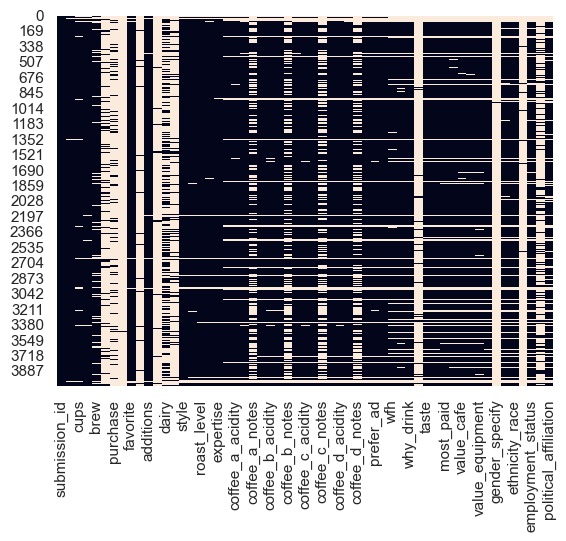

In [5]:
sns.heatmap(df.isnull(), cbar=False)


In [6]:
# drop rows where target variable is null
df = df.dropna(subset=['roast_level'])

### Features that seem important
- target: roast_level

- age, cups, where_drink, brew, favorite, additions, dairy, style, caffeine, expertise, prefer_abc, prefer_ad, prefer_overall, wfh, total_spend, why_drink (im guessing people who drink for taste will like lighter roasts bc of specialty coffee), taste, know_source, most_paid, most_willing, value_cafe, spent_equipment, gender, education_level, ethnicity_race, employment_status, number_children, political_affiliation (use some sources for the report for this - liberal latte etc...)

- coffee abcd ratings (the tasting notes column is useful but i dont know how I could encode/quantify this since its so variable, but i think if someone is able to describe the notes in detail they are more likely to enjoy it)

- brew_other, purchase, sweetener -> could be useful but mostly null

In [7]:
ordinal_important = ['age', 'cups', 'expertise', 'roast_level']

nominal_important = ['where_drink', 'brew', 'favorite', 'style', 'prefer_overall']

ordinal_trivial = ['caffeine', 'total_spend', 'most_paid', 'most_willing', 'spent_equipment', 'education_level',
                   'number_children', ]

nominal_trivial = ['additions', 'dairy', 'wfh', 'why_drink', 'taste', 'know_source', 'value_cafe', 'gender',
                   'ethnicity_race', 'employment_status', 'political_affiliation']

# lets not use tasting notes for now because its unclear how to quantify or categorize this data
# this is ordinal
sensory_rankings = [
    'coffee_a_bitterness',
    'coffee_a_acidity',
    'coffee_a_personal_preference',
    'coffee_b_bitterness',
    'coffee_b_acidity',
    'coffee_b_personal_preference',
    'coffee_c_bitterness',
    'coffee_c_acidity',
    'coffee_c_personal_preference',
    'coffee_d_bitterness',
    'coffee_d_acidity',
    'coffee_d_personal_preference',
]

features = ordinal_important + nominal_important + ordinal_trivial + nominal_trivial
df = df[features]

In [8]:
# clean data and feature engineering

# fix spelling for consistency
df['brew'] = df['brew'].str.replace('Pour over', 'Pourover', regex=False)

# remove 'years old' from age. We will keep the ranges as bins and not convert to midpoint
# because the bins are common demographic ranges
df['age'] = df['age'].str.replace(' years old', '').str.strip()

# lets map numeric string values of cups to numeric values
# drinking 3 cups of coffee is significantly more caffeine than drinking 1 cup
cups_mapping = {
    'Less than 1': 0.5,  # assumption
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'More than 4': 5  # anybody drinking 5+ cups a day is a major outlier anyway
}
df['cups'] = df['cups'].map(cups_mapping)

children_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    'More than 3': 4
}
df['number_children'] = df['number_children'].map(children_mapping)
df['number_children'] = df['number_children'].fillna(0)

# we just want to classify for light/medium/dark, so lets place rare roast_level values into those categories
# Nordic and Blonde are light roasts. French and Italian roasts are dark
roast_map = {
    'Nordic': 'Light',
    'Blonde': 'Light',
    'French': 'Dark',
    'Italian': 'Dark',
}

df['roast_level'] = df['roast_level'].replace(roast_map)

df = df.rename(columns={'roast_level': 'stated_roast_level'})

abcd_map = {  # this is from the youtube video
    'Coffee A': 'Light',
    'Coffee B': 'Medium',
    'Coffee C': 'Dark',
    'Coffee D': 'Light',
}

# lets define a coffee purist as someone who does not add anything to their coffee
df['is_purist'] = df['additions'].apply(
    lambda x: 1 if pd.isna(x) or x == 'No - just black' else 0
)

df['revealed_roast_level'] = df['prefer_overall'].apply(
    lambda x: 'No preference' if pd.isna(x) else abcd_map[x]
)

df['gender'] = df['gender'].replace(
    ['Non-binary', 'Prefer not to say', 'Other (please specify)'],
    'Other'
)

df.drop(['where_drink', 'why_drink'], axis=1, inplace=True)

# handle columns that have comma seperated lists inside each value
csv_cols = ['brew']
for csv_col in csv_cols:
    df[csv_col] = df[csv_col].str.split(',\s*')  # split by comma + optional spaces

    # Step 2: Use .explode() to turn lists into individual rows
    exploded = df.explode(csv_col)

    # Step 3: One-hot encode, then group back by index
    dummies = pd.get_dummies(exploded[csv_col], prefix=csv_col).groupby(exploded.index).sum()

    # Step 4: Combine back with your original dataframe (if you want)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(csv_col, axis=1)

# what matters most about brew is control and skill because certain brewing methods require the
# user to decide on a variety of brewing parameters
# those who want to be in high control also likely care about coffee more
# let's consolidate our one hot encoded columns into more general groups
df['brew_High_Skill'] = df['brew_Espresso'] | df['brew_Pourover']
df['brew_Medium_Skill'] = df['brew_Bean-to-cup machine'] | df['brew_Coffee brewing machine (e.g. Mr. Coffee)'] | df['brew_French press'] | df['brew_Cold brew'] | df['brew_Other']
df['brew_Low_Skill'] = df['brew_Coffee extract (e.g. Cometeer)'] | df['brew_Instant coffee'] | df['brew_Pod/capsule machine (e.g. Keurig/Nespresso)']

df = df.drop(columns=['brew_Bean-to-cup machine','brew_Coffee brewing machine (e.g. Mr. Coffee)','brew_Coffee extract (e.g. Cometeer)','brew_Cold brew','brew_Espresso','brew_French press','brew_Instant coffee','brew_Pod/capsule machine (e.g. Keurig/Nespresso)','brew_Pourover', 'brew_Other'])

df

,age,cups,expertise,stated_roast_level,favorite,style,prefer_overall,caffeine,total_spend,most_paid,...,value_cafe,gender,ethnicity_race,employment_status,political_affiliation,is_purist,revealed_roast_level,brew_High_Skill,brew_Medium_Skill,brew_Low_Skill
13,<18,2.0,NaN,Light,Other,Full Bodied,NaN,Full caffeine,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,No preference,1,1,0
14,25-34,1.0,7.0,Light,Pourover,Fruity,NaN,Full caffeine,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,No preference,0,0,0
15,<18,3.0,10.0,Light,Pourover,Bright,Coffee B,Full caffeine,>$100,NaN,...,NaN,Other,Other (please specify),Employed full-time,Democrat,0,Medium,1,0,1
16,>65,3.0,7.0,Light,Cortado,Fruity,Coffee D,Full caffeine,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,Light,0,0,0
17,25-34,1.0,6.0,Medium,Regular drip coffee,Sweet,Coffee B,Full caffeine,$40-$60,NaN,...,NaN,Female,White/Caucasian,Employed full-time,Democrat,0,Medium,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,>65,2.0,2.0,Medium,Regular drip coffee,Chocolatey,Coffee A,Full caffeine,$20-$40,$6-$8,...,No,Female,White/Caucasian,Retired,Democrat,0,Light,0,1,0
4038,>65,2.0,2.0,Light,Regular drip coffee,Nutty,Coffee A,Full caffeine,$20-$40,$4-$6,...,No,Male,White/Caucasian,Retired,Republican,0,Light,0,1,0
4039,18-24,1.0,5.0,Light,Latte,Sweet,Coffee C,Full caffeine,$40-$60,$8-$10,...,Yes,Male,White/Caucasian,Employed full-time,Democrat,0,Dark,1,1,1
4040,25-34,2.0,6.0,Medium,Iced coffee,Nutty,Coffee A,Full caffeine,$20-$40,$4-$6,...,Yes,Male,White/Caucasian,Unemployed,Democrat,0,Light,1,0,0


In [9]:
def range_to_midpoint(value):
    if pd.isna(value):
        return np.nan

    # remove commas and spaces
    value = value.replace(',', '').strip()

    # patterns
    less_match = re.match(r'(Less than|<)\$?(\d+)', value)
    more_match = re.match(r'(More than|>)\$?(\d+)', value)
    range_match = re.match(r'\$?(\d+)\s*-\s*\$?(\d+)', value)

    if less_match:
        num = float(less_match.group(2))
        return num / 2  # midpoint between 0 and num
    elif more_match:
        num = float(more_match.group(2))
        return num * 2
    elif range_match:
        low, high = map(float, range_match.groups())
        return (low + high) / 2
    else:
        return np.nan


range_cols = ['total_spend', 'most_paid', 'most_willing', 'spent_equipment']
for col in range_cols:
    df[col + '_mid'] = df[col].apply(range_to_midpoint)
df = df.drop(columns=range_cols)

df

,age,cups,expertise,stated_roast_level,favorite,style,prefer_overall,caffeine,education_level,number_children,...,political_affiliation,is_purist,revealed_roast_level,brew_High_Skill,brew_Medium_Skill,brew_Low_Skill,total_spend_mid,most_paid_mid,most_willing_mid,spent_equipment_mid
13,<18,2.0,NaN,Light,Other,Full Bodied,NaN,Full caffeine,NaN,0.0,...,NaN,0,No preference,1,1,0,NaN,NaN,NaN,NaN
14,25-34,1.0,7.0,Light,Pourover,Fruity,NaN,Full caffeine,NaN,0.0,...,NaN,1,No preference,0,0,0,NaN,NaN,NaN,NaN
15,<18,3.0,10.0,Light,Pourover,Bright,Coffee B,Full caffeine,Bachelor's degree,4.0,...,Democrat,0,Medium,1,0,1,200.0,NaN,NaN,NaN
16,>65,3.0,7.0,Light,Cortado,Fruity,Coffee D,Full caffeine,NaN,0.0,...,NaN,1,Light,0,0,0,NaN,NaN,NaN,NaN
17,25-34,1.0,6.0,Medium,Regular drip coffee,Sweet,Coffee B,Full caffeine,Bachelor's degree,0.0,...,Democrat,0,Medium,1,1,0,50.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,>65,2.0,2.0,Medium,Regular drip coffee,Chocolatey,Coffee A,Full caffeine,Master's degree,2.0,...,Democrat,0,Light,0,1,0,30.0,7.0,5.0,NaN
4038,>65,2.0,2.0,Light,Regular drip coffee,Nutty,Coffee A,Full caffeine,Bachelor's degree,2.0,...,Republican,0,Light,0,1,0,30.0,5.0,3.0,NaN
4039,18-24,1.0,5.0,Light,Latte,Sweet,Coffee C,Full caffeine,Some college or associate's degree,0.0,...,Democrat,0,Dark,1,1,1,50.0,9.0,NaN,400.0
4040,25-34,2.0,6.0,Medium,Iced coffee,Nutty,Coffee A,Full caffeine,Bachelor's degree,0.0,...,Democrat,0,Light,1,0,0,30.0,5.0,9.0,200.0


In [10]:
# almost everybody answered yes for taste so probably not that predictive of a feature
df = df.drop(columns=['taste', 'additions', 'dairy', 'caffeine', 'ethnicity_race', 'number_children'])
# df = df.drop(columns=sensory_rankings)


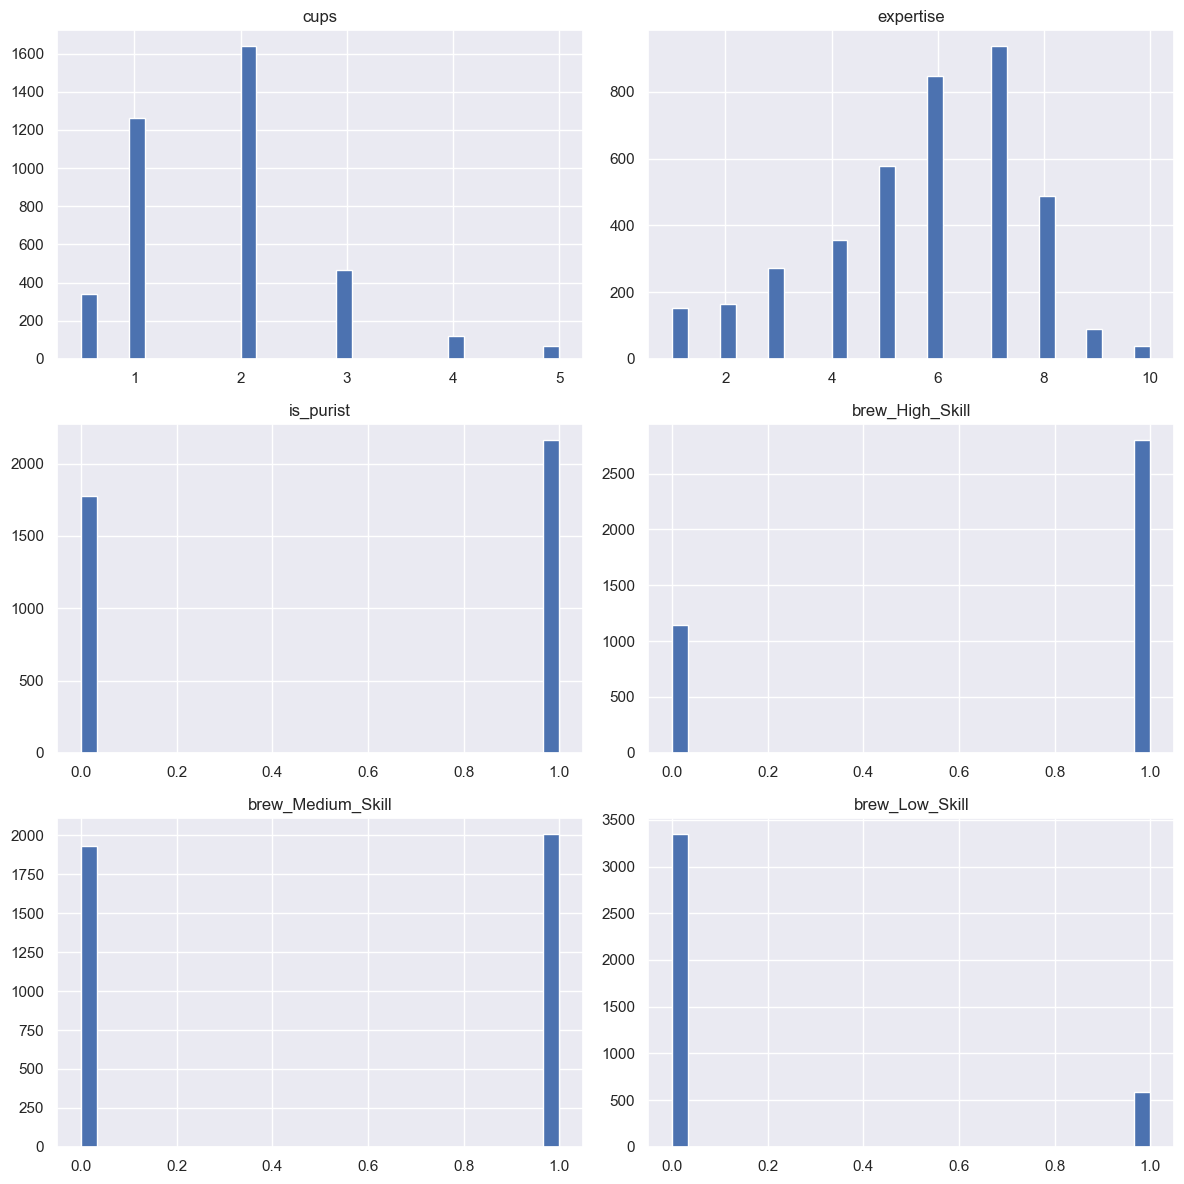

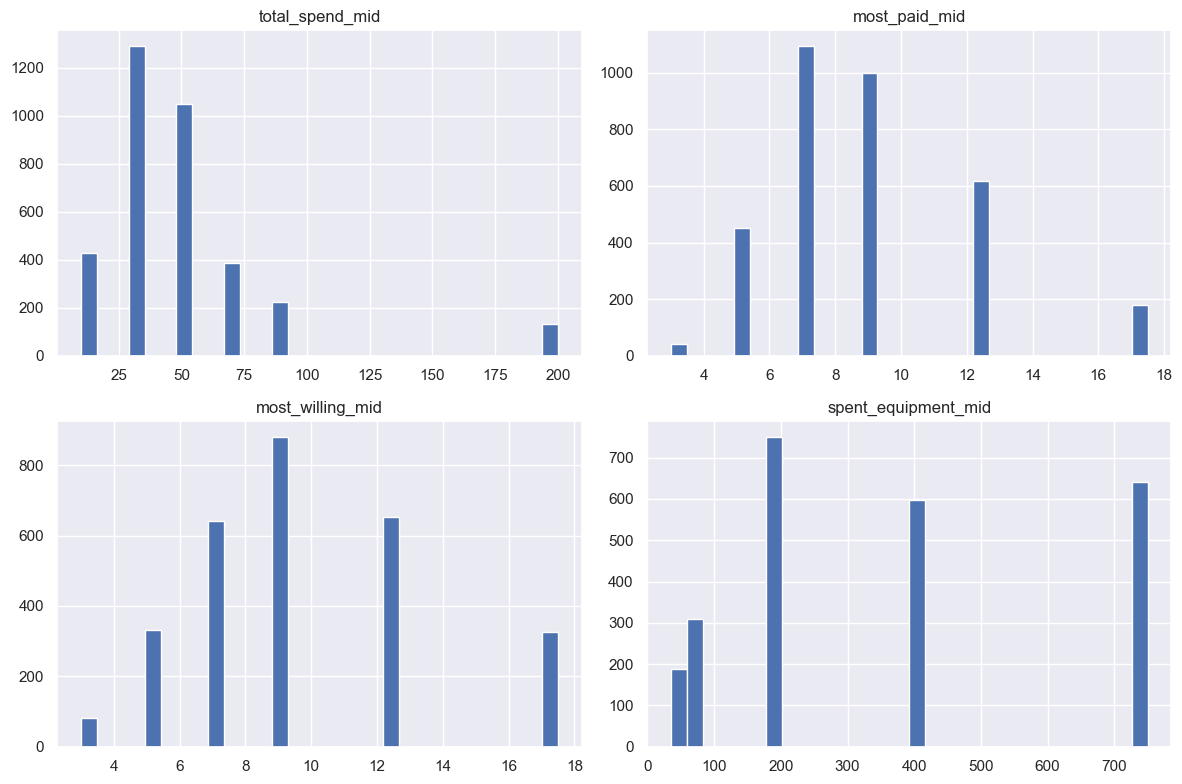

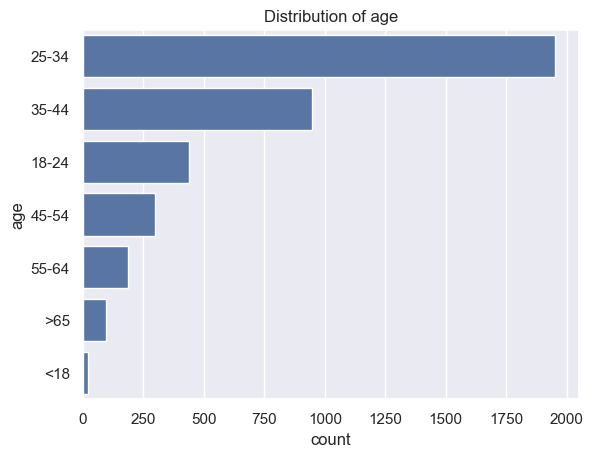

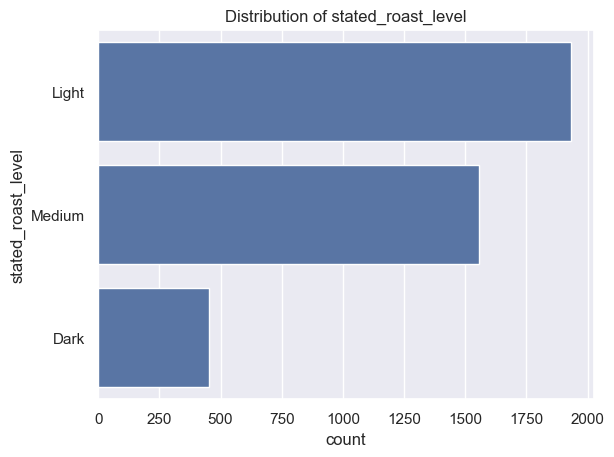

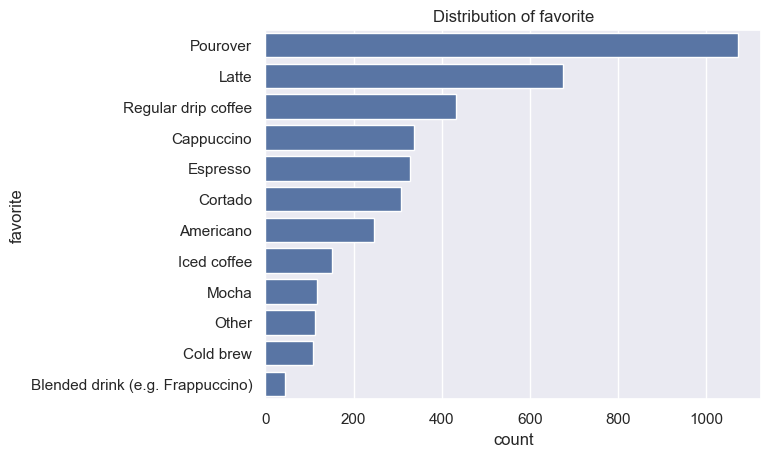

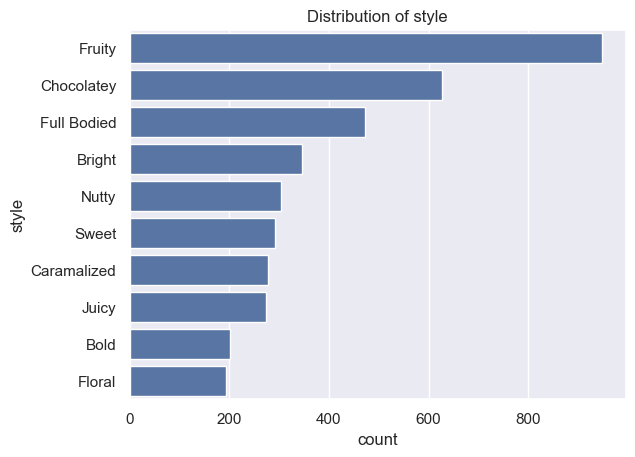

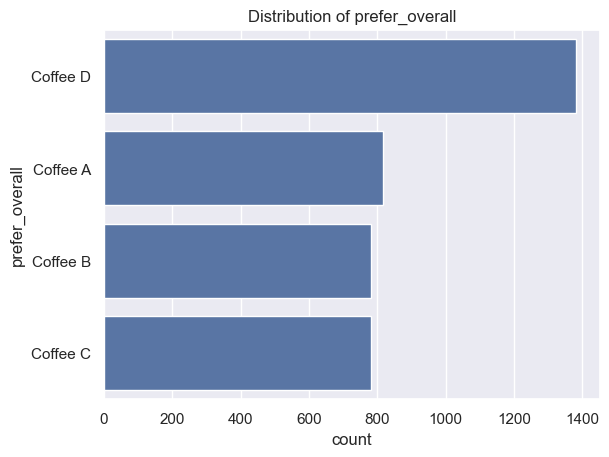

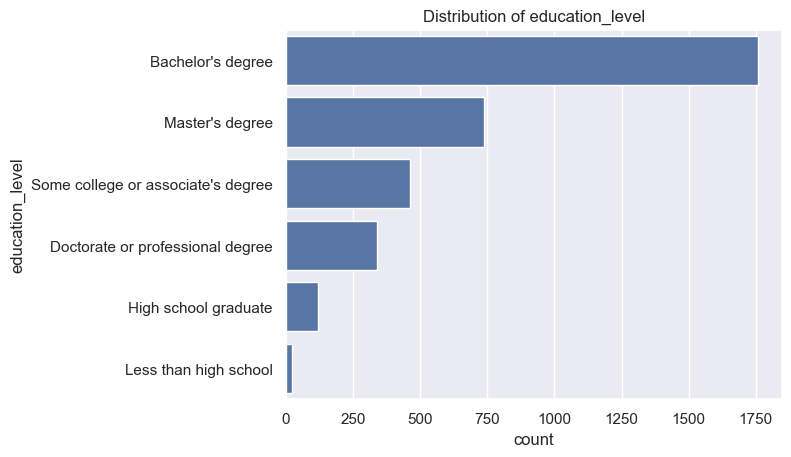

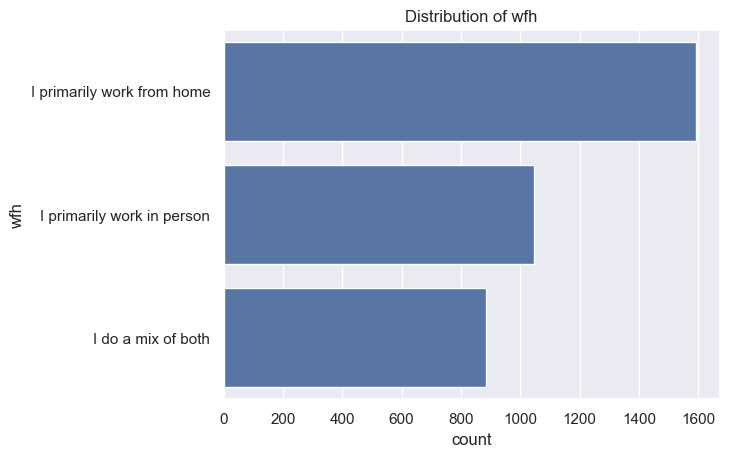

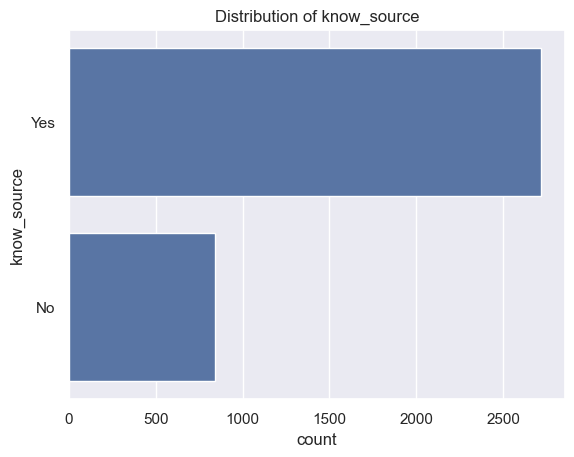

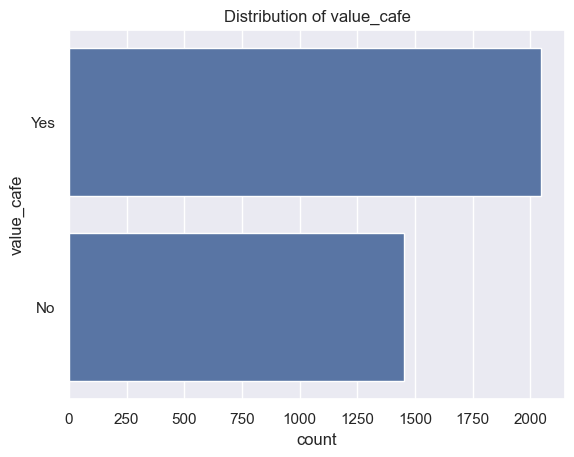

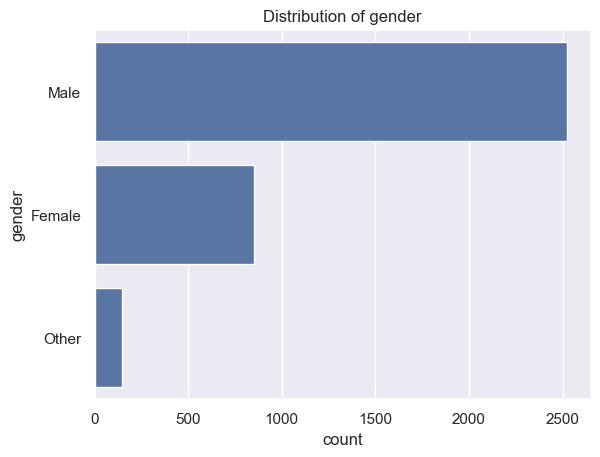

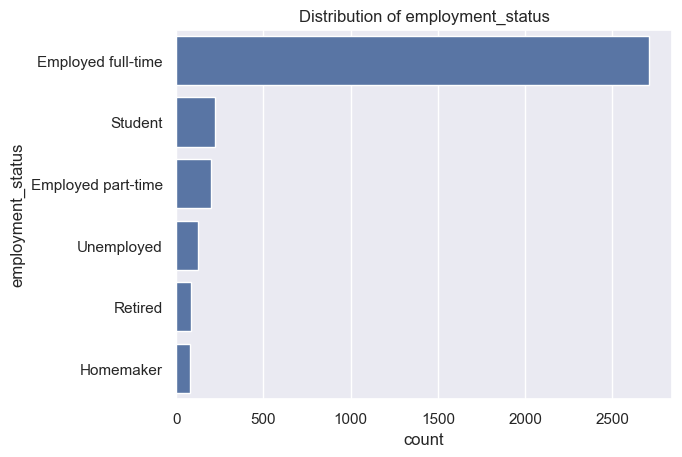

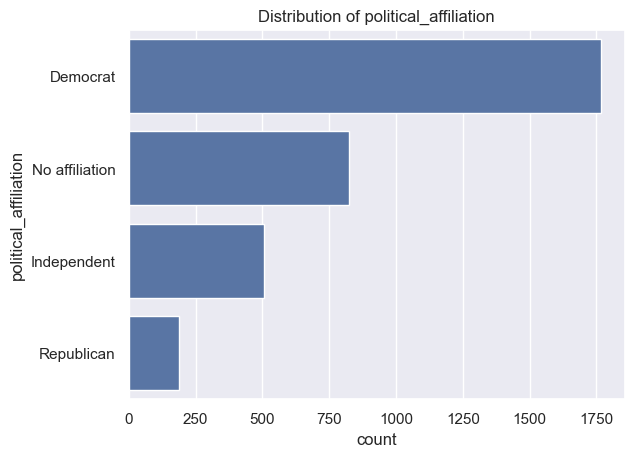

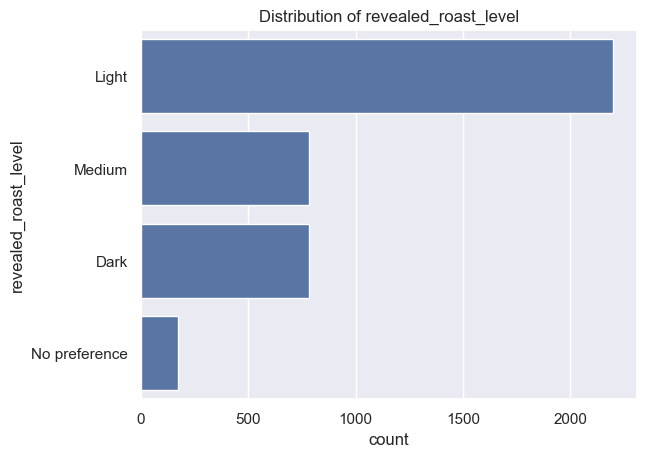

In [11]:
num_cols = df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns


n_cols = len(num_cols)

plots_per_fig = 6

n_figs = math.ceil(n_cols / plots_per_fig)

for i in range(n_figs):
    cols = num_cols[i * plots_per_fig: (i + 1) * plots_per_fig]
    n_subplots = len(cols)

    n_rows = math.ceil(n_subplots / 2)
    n_cols_fig = 2

    fig, axes = plt.subplots(n_rows, n_cols_fig, figsize=(12, 4 * n_rows))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        df[col].hist(bins=30, ax=ax)
        ax.set_title(col)

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

for csv_col in cat_cols:
    sns.countplot(y=csv_col, data=df, order=df[csv_col].value_counts().index)
    plt.title(f"Distribution of {csv_col}")
    plt.show()

In [12]:
print(df.isnull().sum()[df.isnull().sum() > 0])

age                         9
cups                       46
expertise                  18
favorite                   10
style                       7
prefer_overall            173
education_level           502
wfh                       417
know_source               381
value_cafe                440
gender                    417
employment_status         521
political_affiliation     651
total_spend_mid           430
most_paid_mid             554
most_willing_mid         1025
spent_equipment_mid      1453
dtype: int64


In [13]:
# save dataframe
df.to_csv('coffee_survey_processed.csv', index=False)

favorite
Pourover                            1071
Latte                                674
Regular drip coffee                  432
Cappuccino                           337
Espresso                             328
Cortado                              308
Americano                            246
Iced coffee                          151
Mocha                                118
Other                                113
Cold brew                            107
Blended drink (e.g. Frappuccino)      45
Name: count, dtype: int64

In [14]:
print('stated == revealed', len(df[df['stated_roast_level'] == df['revealed_roast_level']]))
print('stated != revealed',len(df[df['stated_roast_level'] != df['revealed_roast_level']]))


stated == revealed 2008
stated != revealed 1932
